In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
import pandas as pd
import numpy as np

import  matplotlib.pyplot as plt
import pickle

from chemistry import Molecule
from util import score
from pprint import pprint


In [3]:
with open('../data/molecules_enh.pickle', 'rb') as f:
    molecules = pickle.load(f)

m = molecules['dsgdb9nsd_000002']
m.compute_path(2, 3)
m

m = molecules['dsgdb9nsd_000014']
i0, i1 = 2, 3
p0, p1 = m.positions[i0], m.positions[i1]
mid = (p0 + p1) * 0.5
other_atoms = list(range(m.n_atoms))
other_atoms.remove(i0)
other_atoms.remove(i1)
p = m.positions[other_atoms]
diff = p - mid
dist = np.linalg.norm(diff, axis=1)
print(dist)
print(dist.argsort()[0:2])
print(dist[dist.argsort()[0:2]])

In [4]:
structures = pd.read_feather('../data/structures_enh.feather')
molecules_df = pd.read_feather('../data/molecules.feather')
labelled = pd.read_feather('../data/train.feather')
unlabelled = pd.read_feather('../data/test.feather')

In [5]:
labelled_enh = labelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#labelled_enh.head(32)

In [6]:
unlabelled_enh = unlabelled.merge(molecules_df, left_on='molecule_name', right_on='molecule_name')
#unlabelled_enh.head(32)

In [ ]:
len(labelled), len(labelled_enh)

In [ ]:
from models import SKModel, partition_data

data_df = labelled[labelled.type == '1JHC'].head(10000)
#data_df = labelled_enh.head(16)
train_df, valid_df, test_df = partition_data(data_df, train_frac=1)
train_df = train_df#.copy()
        
model = SKModel(dict(molecules=molecules,
                     structures=structures), fit_args={})
input_df, numeric_df, output_df = model.setup_data(train_df, train_df)
None

In [ ]:
numeric_df.dtypes

In [ ]:
model.structures.columns

In [ ]:
list(input_df.columns)

In [ ]:
labelled['type'].unique()

In [ ]:
list(numeric_df.columns)

In [ ]:
unlabelled_enh['type'].iloc[0]

In [ ]:
columns = list(filter(lambda c: c.startswith('sergii') and (c.find('cos') != -1 or c.find('sin') != -1), numeric_df.columns))

In [ ]:
list(zip(input_df.columns, input_df.loc[14], input_df.loc[15]))

In [ ]:
import itertools

In [15]:
lgb_model_args = dict(n_jobs=8,
                      max_depth=16,
                      boosting_type='dart',
                      num_leaves=1024, #65536, #128,
                      min_child_samples=20,
                      min_data_in_leaf=100,
                      learning_rate=0.2,
                      n_estimators=2000,
                      reg_alpha=0.1,
                      reg_lambda=0.3,
                      bagging_fraction = 0.9,
                      bagging_freq = 5,
                      num_iterations=2000
                      )
lgb_fit_args = dict(early_stopping_rounds=100, verbose=100)

Training 50000 samples for 3JHH
  Setting up data


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



  Fitting model


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/lightgbm/callback.py:189: UserWarning:

Early stopping is not available in dart mode



[100]	valid_0's l2: 0.2226
[200]	valid_0's l2: 0.155178
[300]	valid_0's l2: 0.133306
[400]	valid_0's l2: 0.119372
[500]	valid_0's l2: 0.114777
[600]	valid_0's l2: 0.116239
[700]	valid_0's l2: 0.110484
[800]	valid_0's l2: 0.110814
[900]	valid_0's l2: 0.107919
[1000]	valid_0's l2: 0.107328
[1100]	valid_0's l2: 0.106102
[1200]	valid_0's l2: 0.105578
[1300]	valid_0's l2: 0.104571
[1400]	valid_0's l2: 0.103034
[1500]	valid_0's l2: 0.104144
[1600]	valid_0's l2: 0.101935
[1700]	valid_0's l2: 0.10121
[1800]	valid_0's l2: 0.101373
[1900]	valid_0's l2: 0.100435
[2000]	valid_0's l2: 0.100222
  Setting up data
  Fitting model
  Evaluating model
3JHH score: -1.7289618648469296 (trained on 50000 elements)


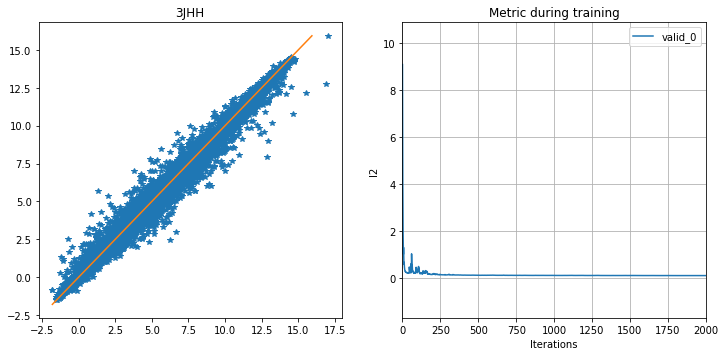

In [16]:
from models import LGBModel
from models import partition_data

#coupling_types = sorted(labelled_enh.type.unique())
coupling_types = ['3JHH']
models = {}
def run_test(data, count=None):
    global model
    
    plt.figure(figsize=(25, 25))
    for i, t in enumerate(coupling_types, 1):    
        data_df = data[data.type == t]
        if count is not None:
            data_df = data_df.head(count)

        train_df, valid_df, test_df = partition_data(data_df)
        
        if len(train_df) < 10 or len(test_df) < 10:
            continue
            
        print(f'Training {len(train_df)} samples for {t}')

        model = LGBModel(dict(molecules=molecules, 
                              structures=structures,
                              verbose=True),
                         lgb_model_args, lgb_fit_args)
        models[t] = model

        model.fit(train_df, train_df, valid_df, valid_df)
        output, score = model.evaluate(test_df, test_df)
        
        print(f'{t} score: {score} (trained on {len(train_df)} elements)')
        plt.subplot(4, 4, 2 * i - 1)
        plt.plot(test_df.scalar_coupling_constant, output, '*')
        mn = min(test_df.scalar_coupling_constant.min(), output.min())
        mx = min(test_df.scalar_coupling_constant.max(), output.max())
        plt.plot([mn, mx], [mn, mx])
        plt.title(t)
        
        ax = plt.subplot(4, 4, 2 * i)
        model.plot_metric(ax=ax)
    plt.show()
        
run_test(labelled_enh, 100000)


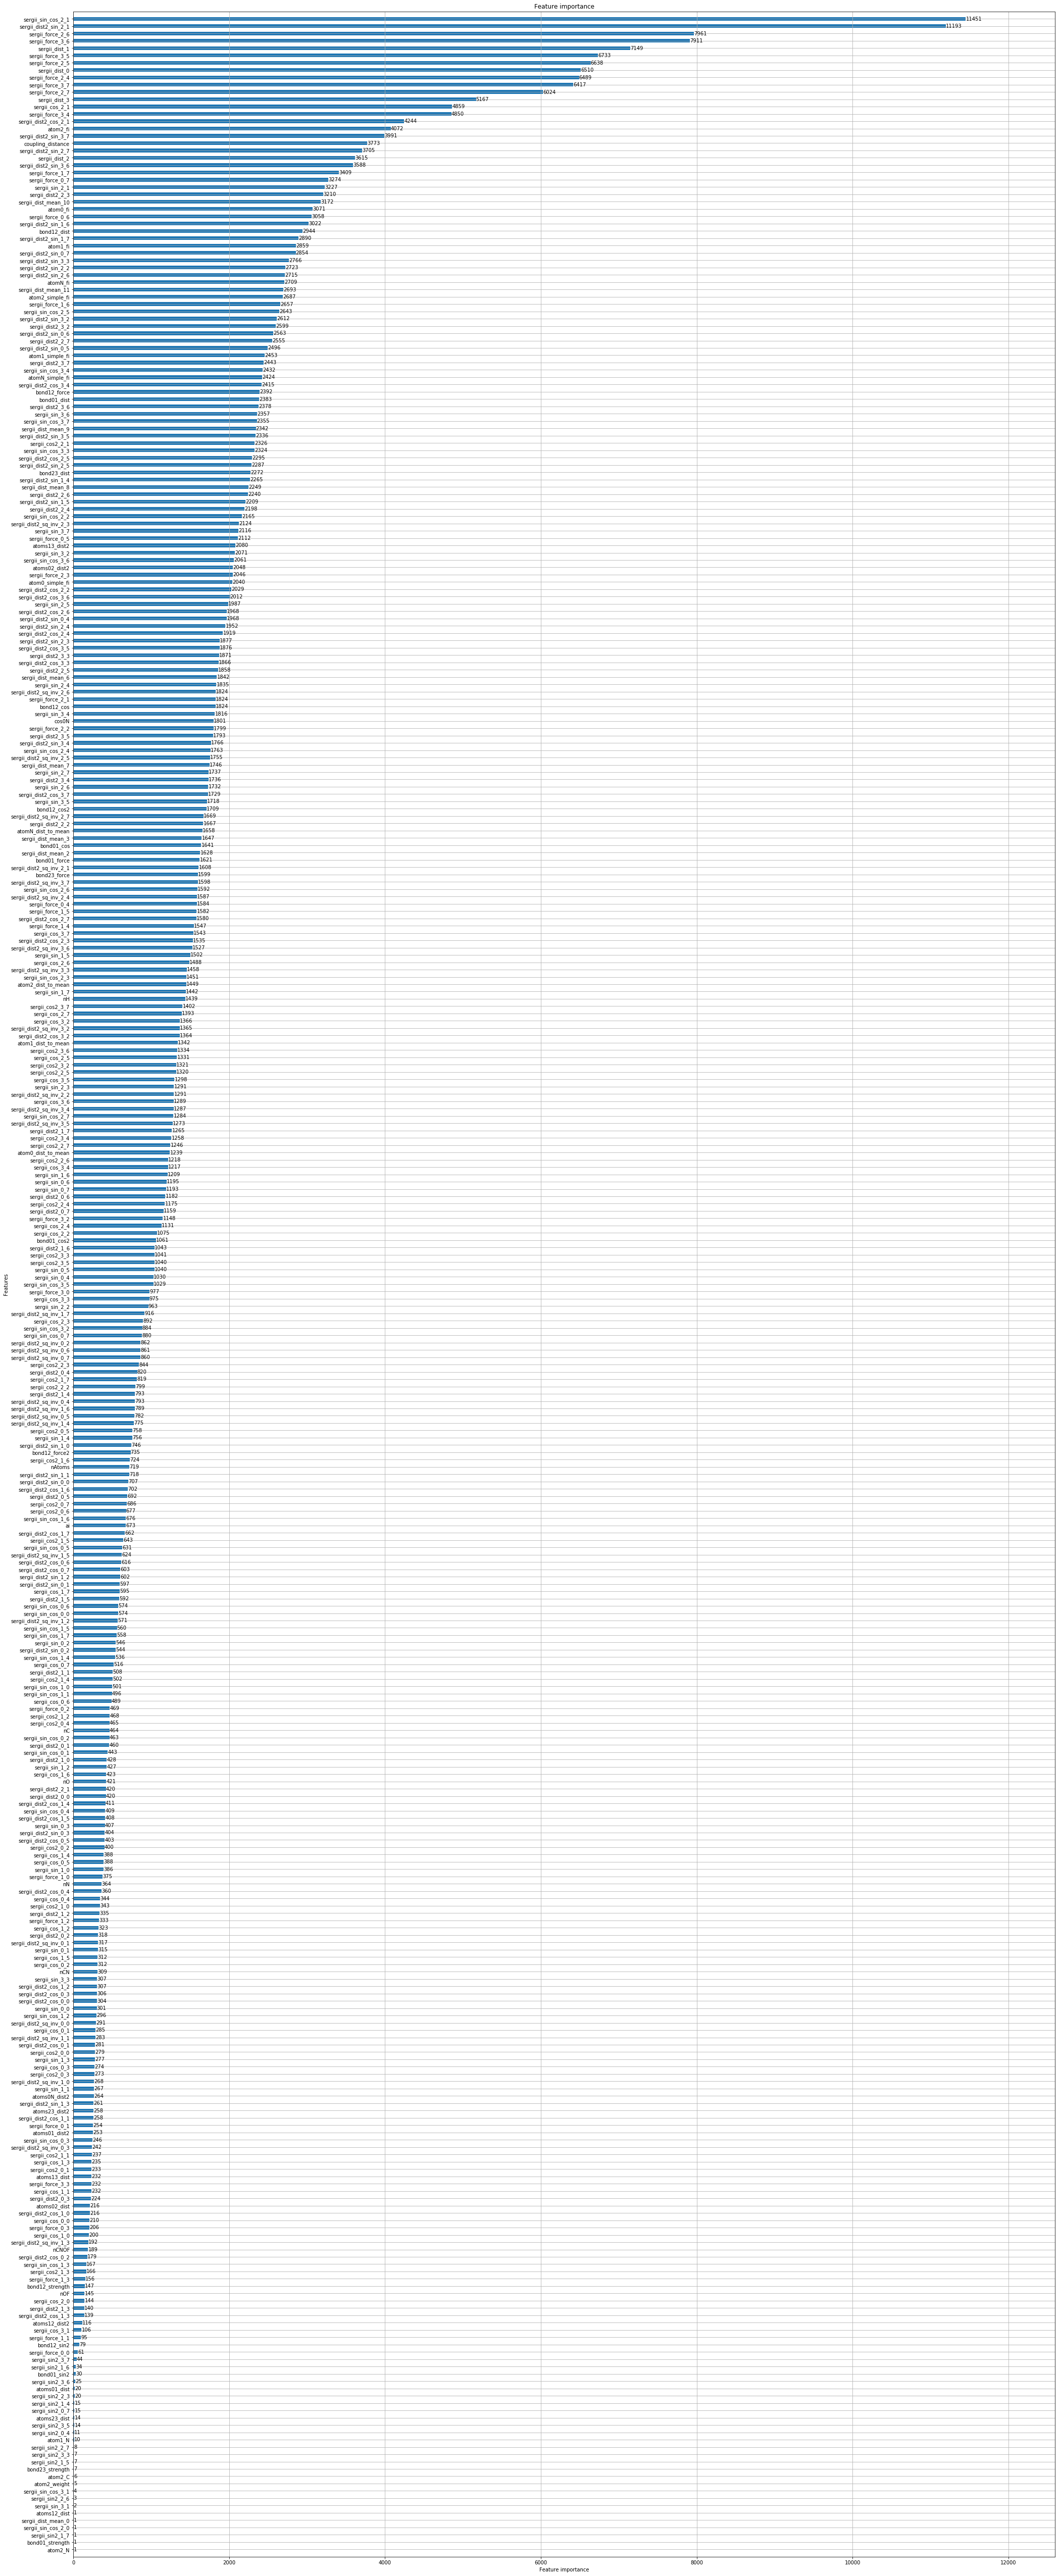

In [17]:
from models import LGBModel
fig = plt.figure(figsize=(27, 70))
model.plot_importance(ax=fig.add_axes([0, 0, 1, 1]), height=0.5)
plt.show()

In [ ]:
model.last_numeric_input_df.loc[:, ['bond12_cos']].head()

In [14]:
len(list(model.last_numeric_input_df.columns))

467

In [18]:
lgb_model_args = dict(n_jobs=8,
                      max_depth=16,
                      boosting_type='dart',
                      num_leaves=1024, #65536, #128,
                      min_child_samples=20,
                      min_data_in_leaf=100,
                      learning_rate=0.2,
                      n_estimators=2000,
                      reg_alpha=0.1,
                      reg_lambda=0.3,
                      bagging_fraction = 0.9,
                      bagging_freq = 5,
                      num_iterations=2000
                      )
lgb_fit_args = dict(verbose=100)

In [19]:
from models import LGBModel

def train(data):
    models = {}
    for t in sorted(data.type.unique()):
        train_df = data[data.type == t]
        print(f'Training {len(train_df)} samples for {t}')
        model = LGBModel(dict(molecules=molecules, 
                              structures=structures),
                         lgb_model_args, lgb_fit_args)
        models[t] = model
        model.fit(train_df, train_df)
    
    return models

#models = train(labelled_enh.head(200))
models = train(labelled_enh)

Training 709416 samples for 1JHC


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



Training 43363 samples for 1JHN
Training 1140674 samples for 2JHC
Training 378036 samples for 2JHH
Training 119253 samples for 2JHN
Training 1510379 samples for 3JHC
[12, 2, 7] 12 7 
 dsgdb9nsd_133831
[17, 7, 2] 17 2 
 dsgdb9nsd_133831
Training 590611 samples for 3JHH
Training 166415 samples for 3JHN


In [20]:
def predict(data, models):
    out_df = None
    
    for t in sorted(data.type.unique()):
        predict_df = data[data.type == t]
        print(f'Predicting {len(predict_df)} samples for {t}')
        output = models[t].predict(predict_df)
        
        id = predict_df['id']
        out_df_coupling = pd.DataFrame(data={'id':id, 'scalar_coupling_constant':output}, index=predict_df.index)
        
        if out_df is None:
            out_df = out_df_coupling
        else:
            out_df = out_df.append(out_df_coupling).sort_index()

    return out_df.sort_index()
    
#prediction = predict(unlabelled_enh.head(200), models)
prediction = predict(unlabelled_enh, models)

Predicting 380609 samples for 1JHC
Predicting 24195 samples for 1JHN


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Predicting 613138 samples for 2JHC
[13, 4, 3, 0, 1, 8] 13 8 
 dsgdb9nsd_037497
[17, 8, 1, 0, 3, 4] 17 4 
 dsgdb9nsd_037497
[12, 6, 7, 1] 12 1 
 dsgdb9nsd_072320
[14, 3, 2, 1, 8] 14 8 
 dsgdb9nsd_133863
[20, 7, 0, 1, 8] 20 8 
 dsgdb9nsd_133863


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Predicting 203126 samples for 2JHH


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Predicting 64424 samples for 2JHN


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Predicting 811999 samples for 3JHC
[11, 1, 0, 3, 4] 11 4 
 dsgdb9nsd_037497
[13, 4, 3, 0, 1] 13 1 
 dsgdb9nsd_037497
[13, 4, 5, 6, 7] 13 7 
 dsgdb9nsd_037497
[14, 5, 6, 7, 8] 14 8 
 dsgdb9nsd_037497
[15, 5, 6, 7, 8] 15 8 
 dsgdb9nsd_037497
[16, 7, 6, 5, 4] 16 4 
 dsgdb9nsd_037497
[17, 8, 7, 6, 5] 17 5 
 dsgdb9nsd_037497
[9, 0, 1, 7, 6] 9 6 
 dsgdb9nsd_072320
[10, 2, 1, 7, 6] 10 6 
 dsgdb9nsd_072320
[11, 2, 1, 7, 6] 11 6 
 dsgdb9nsd_072320
[12, 6, 7, 1, 2] 12 2 
 dsgdb9nsd_072320
[14, 3, 2, 1, 0, 7] 14 7 
 dsgdb9nsd_133863
[20, 7, 0, 1, 2, 3] 20 3 
 dsgdb9nsd_133863


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Predicting 317435 samples for 3JHH
[13, 4, 3, 0, 1, 8, 17] 13 17 
 dsgdb9nsd_037497


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Predicting 90616 samples for 3JHN
[17, 8, 1, 0, 3] 17 3 
 dsgdb9nsd_037497


/home/gautham/apps/anaconda3/envs/kaggle-cpu/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [21]:
prediction.head()

,id,scalar_coupling_constant
0,4658147,19.469522
1,4658148,189.990068
2,4658149,11.188996
3,4658150,163.440222
4,4658151,18.558023


In [22]:
prediction.to_csv('../data/pred.csv',index=False)